In [1]:
#217 page
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
def sin(x, T=100):
    return np.sin(2.0*np.pi*x/T)

In [3]:
def toy_preoblem(T=100, ampl=0.05):
    x = np.arange(0,2*T+1)
    noise = ampl*np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x)+noise

In [4]:
T = 100
f = toy_preoblem(T)

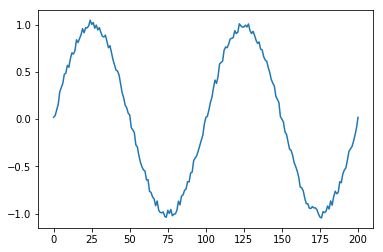

In [5]:
plt.plot(f)

In [6]:
length_of_sequences = 2*T
maxlen = 25

data = []
target = []

#predict the value in t+1 by t-24 ~  t during 2T period
for i in range(0,length_of_sequences-maxlen+1):
    data.append(f[i:i+maxlen])
    target.append(f[i+maxlen])

In [7]:
X = np.array(data).reshape(len(data),maxlen,1)
Y = np.array(target).reshape(len(data),1)

In [8]:
N_train = int(len(data)*0.9)
N_validation = len(data)-N_train

X_train, X_validation, Y_train, V_validation =train_test_split(X,Y,test_size=N_validation)

# TensorFlow

In [9]:
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
n_in = len(X[0][0])
n_hidden = 20
n_out =len(Y[0])
n_batch= 10

cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
initial_state = cell.zero_state(n_batch, tf.float32)

state = initial_state
output= []

